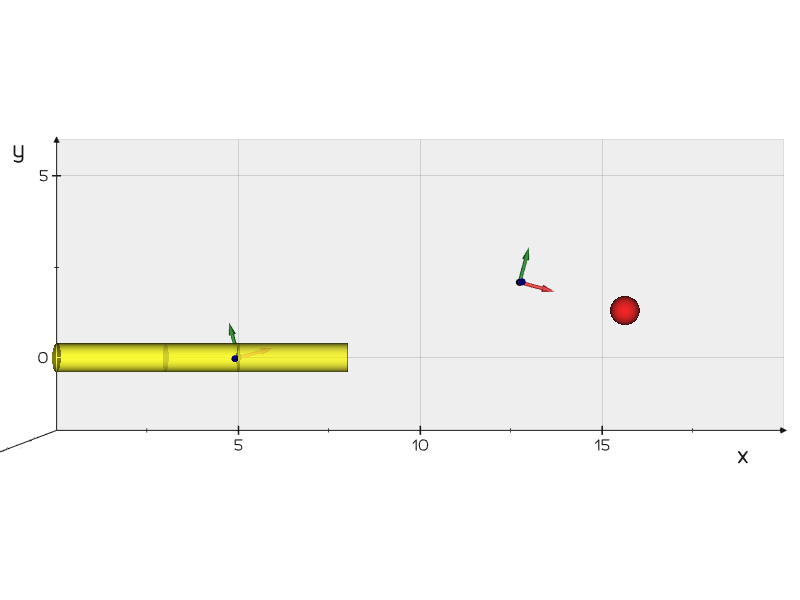

In [4]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
from vedo import *

# Color of robot arm
robotColor = "green"
jointColor = "white"

def RotationMatrix(theta, axis_name):
    """ calculate single rotation of \(\theta\) matrix around x,y or z
        code from: https://programming-surgeon.com/en/euler-angle-python-en/
    input
        theta = rotation angle(degrees)
        axis_name = 'x', 'y' or 'z'
    output
        3x3 rotation matrix
    """

    c = np.cos(theta * np.pi / 180)
    s = np.sin(theta * np.pi / 180)
    if axis_name =='x':
        rotation_matrix = np.array([[1, 0,  0],
                                    [0, c, -s],
                                    [0, s,  c]])
    if axis_name =='y':
        rotation_matrix = np.array([[ c,  0, s],
                                    [ 0,  1, 0],
                                    [-s,  0, c]])
    elif axis_name =='z':
        rotation_matrix = np.array([[c, -s, 0],
                                    [s,  c, 0],
                                    [0,  0, 1]])
    return rotation_matrix

def createCoordinateFrameMesh():
    """Returns the mesh representing a coordinate frame
    Args:
      No input args
    Returns:
      F: vedo.mesh object (arrows for axis)
    """     
    
    _shaft_radius = 0.05
    _head_radius = 0.10
    _alpha = 1
    
    # x-axis as an arrow  
    x_axisArrow = Arrow(
                        start_pt=(0, 0, 0),
                        end_pt=(1, 0, 0),
                        s=None,
                        shaft_radius=_shaft_radius,
                        head_radius=_head_radius,
                        head_length=None,
                        res=12,
                        c='red',
                        alpha=_alpha
    )

    # y-axis as an arrow  
    y_axisArrow = Arrow(
                        start_pt=(0, 0, 0),
                        end_pt=(0, 1, 0),
                        s=None,
                        shaft_radius=_shaft_radius,
                        head_radius=_head_radius,
                        head_length=None,
                        res=12,
                        c='green',
                        alpha=_alpha
    )

    # z-axis as an arrow  
    z_axisArrow = Arrow(
                        start_pt=(0, 0, 0),
                        end_pt=(0, 0, 1),
                        s=None,
                        shaft_radius=_shaft_radius,
                        head_radius=_head_radius,
                        head_length=None,
                        res=12,
                        c='blue',
                        alpha=_alpha
    )
    
    originDot = Sphere(pos=[0,0,0], 
                       c="black", 
                       r=0.10)

    # Combine the axes together to form a frame
    F = x_axisArrow + y_axisArrow + z_axisArrow + originDot
    
    return F

def getLocalFrameMatrix(R_ij, t_ij): 
    """Returns the matrix representing the local frame
    Args:
      R_ij: rotation of Frame j w.r.t. Frame i 
      t_ij: translation of Frame j w.r.t. Frame i 
    Returns:
      T_ij: Matrix of Frame j w.r.t. Frame i. 
    """             
    # Rigid-body transformation [ R t ]
    T_ij = np.block([[R_ij,                t_ij],
                     [np.zeros((1, 3)),       1]])
    
    return T_ij

def forward_kinematics(Phi, L1, L2, L3, L4):
    """
    Calculate the local-to-global frame matrices, and the location of the end-effector.
    
    Args:
        Phi (4x1 nd.array): Array containing the four joint angles
        L1, L2, L3, L4 (float): Lengths of the parts of the robot arm.
        
    Returns:
        T_01, T_02, T_03, T_04: 4x4 nd.arrays of local-to-global matrices for each frame.
        e: 3x1 nd.array of 3-D coordinates, the location of the end-effector in space.
    """
    # Rotation matrices     
    R_01 = RotationMatrix(Phi[0], 'z')  
    R_12 = RotationMatrix(Phi[1], 'z')
    R_23 = RotationMatrix(Phi[2], 'z')
    R_34 = RotationMatrix(Phi[3], 'z')
    
    # Transformations
    t_01 = np.array([[L1], [0], [0]]) 
    T_01 = getLocalFrameMatrix(R_01, t_01)
    
    t_12 = np.array([[L2], [0], [0]])
    T_12 = getLocalFrameMatrix(R_12, t_12)

    t_23 = np.array([[L3], [0], [0]])
    T_23 = getLocalFrameMatrix(R_23, t_23)

    t_34 = np.array([[L4], [0], [0]]) 
    T_34 = getLocalFrameMatrix(R_34, t_34)
    
    # Overall transformation matrix 
    T_04 = T_01 @ T_12 @ T_23 @ T_34  
    
    # Extract end-effector position       
    e = T_04[0:3, 3]   
    
    return T_01, T_02, T_03, T_04, e

# Plotter setup 
plt = Plotter() 
axes = Axes(xrange=(0,20), yrange=(-2,6), zrange=(0,6))  # Fix: add ranges to Axes

# Link lengths
L1 = 5   
L2 = 8
L3 = 3
L4 = 0

# Joint angles  
phi1 = 15     
phi2 = -30
phi3 = 0      

# Calculate transformations
Phi = np.array([phi1, phi2, phi3, 0])  # Include all 4 joint angles
T_01, T_02, T_03, T_04, e = forward_kinematics(Phi, L1, L2, L3, L4)

# Create arm mesh and transform
link1_mesh = Cylinder(r=0.4, height=L1, pos=(L1/2, 0, 0), c="yellow", alpha=0.8, axis=(1,0,0))
Frame1Arrows = createCoordinateFrameMesh()
Frame1Arrows.apply_transform(T_01)

link2_mesh = Cylinder(r=0.4, height=L2, pos=(L2/2, 0, 0), c="yellow", alpha=0.8, axis=(1,0,0))
Frame2Arrows = createCoordinateFrameMesh()
Frame2Arrows.apply_transform(T_02)

# Link 3
link3_mesh = Cylinder(r=0.4, height=L3, pos=(L3/2, 0, 0), c="yellow", alpha=0.8, axis=(1,0,0))
Frame3Arrows = createCoordinateFrameMesh()
Frame3Arrows.apply_transform(T_03)

# End-effector
end_effector = Sphere(pos=e, r=0.4, c="red", alpha=0.8)

# Display full arm
plt.show([Frame1Arrows, link1_mesh, Frame2Arrows, link2_mesh, Frame3Arrows, link3_mesh, end_effector], axes)
